# Introduction

* The following notebook is a simple implementation of a neural ordinary differential equation. This model is referred to a time-stepping model since the neural network is used in conjuction with a standard ODE solver. 

**Ensemble ML model for directly modeling the rhs of the URANS equations for homogeneous SST**
* Input:  y0, t
* Output: y(t)
* **Flow field**: Various SST cases
* **NN framework**: PyTorch
* **Data script**: [DataAcqu_NODE.ipynb](DataAcqu_NODE.ipynb)

# Import Packages

In [1]:
# import all python, pytorch, and ML libraries, classes, and functions
from NN_funcs import *

# inport plotting routines
import matplotlib.pyplot as plt
import plotting as plots

# Hyperparameters

In [2]:
# Data type
casenum         = [1]        # dataset case number(s) (see DataAcqu_LSTM.ipynb or data_funcs.py)
# parameters used for data acquisition
target_T        = 1          # target time period for sampling frequency
seq_len_T       = 64         # target sequence length (sampling frequency) of LSTM input for target_T
dt_target       = target_T/seq_len_T

normEnergy      = True       # normalize inputs to dimension of energy and non-dimensionalize both i/p & o/p using total energy at initial state
interpIO        = True       # interpolate data so that seq dt are same
set_dt_seq      = True       # set dt for `interpIO` such that time length of `seq_len` data points = dt_T time period
dt_T            = 1.0        # dt for interpIO
if set_dt_seq:
    seq_len     = np.max([int(dt_T/dt_target), 1])  # sequence length (lag time) for LSTM input
else:
    seq_len     = seq_len_T                         # sequence length (lag time) for LSTM input

if seq_len==1:
    raise Exception(f'Need more than 1 elements in the sequence for integration. '\
                    f'Current: seq_len_T={seq_len_T}, dt_T={dt_T}, seq_len={seq_len}. Exiting...')

add_IP_time     = False      # add time info as an additional input
add_IP_ke_pe_T  = False      # add ke and pe decay time scales as additional inputs (make sure the IPs are normalized)
add_IP_Fr_Gn    = False      # add Frh and Gn as additional inputs

Ntrainper       = 0.9        # number of training data (%)

# Hyperparameters
# data
n_val         = 0.1          # validation data (ratio)
n_inputs      = 4            # number of inputs
n_outputs     = 4            # number of outputs
# network architecture
model_name    = 'NODE_MLP'       # model name: 'SingleMLP' 'ResNet' 'DenseNet' 'LSTM' 'NODE_MLP'
NODE_method   = 'rk4'         # ODE solver in NODE model
NODE_rtol     = 1e-3         # relative tolerance in NODE
NODE_atol     = 1e-4         # absolute tolerance in NODE
# dense layers
n_per_layer   = 40           # number of neurons on all hidden dense layers (manually update model if needed)
n_layers      = 10            # number of dense layers - ResNet, DenseNet
drp_in        = 0            # probability value for input dropout 
drp_hd        = 0            # probability value for hidden layer dropout
# other settings
lkyReLU_alpha = 0.1          # slope of leakyReLU
lrate         = 5e-2         # learning rate
gamma         = 0.99         # for learning rate scheduler
# training parameters
nepoch        = 10         # number of training epochs (additional for restart runs)
batch_size    = 100          # batch size
scaleData     = False        # scale data (e.g.: naive min-max scaling of I/O)
plot_itr      = True         # plot training curves and testing
plot_epoch    = 20          # epoch interval for plotting

# Save NN model
HDdir         = '.'           # root dir of all data and models
saveNN        = True         # save the model, learning history
restartTrain  = False        # restart training
ensmbleTrain  = False        # restart training with ensemble (first restart training for a few epoch and figure out ensm_errval)
ensmb_errval  = 1.7e-6       # models with error below this will be used for ensemble. Choose manually based on original training curve
nepoch_in     = 4000         # nepoch of original (old) model
lrate_restart = 5e-4         # new lrate

# Device settings
disable_device  = True        # disable GPU?

In [3]:
# get casenames
casename     = [get_casename(i) for i in casenum]

# model filename
savefilename = f'{HDdir}/Data_models/SSTRANS_EnergyEqn_normEnergy{int(normEnergy)}_interpIO{int(interpIO)}'\
                f'_setdt{int(set_dt_seq)}-T{dt_T}_'\
                f'IPtime{int(add_IP_time)}_IPKEPEtime{int(add_IP_ke_pe_T)}_IPFrGn{int(add_IP_Fr_Gn)}'
for i in range(len(casenum)):              # casename(s)
    savefilename = f'{savefilename}_{casename[i]}'
savefilename = f'{savefilename}_PyTModel_{model_name}_seqlen{seq_len}_'\
                f'nMLPLayers{n_layers}_nNeurons{n_per_layer}_batch{batch_size}_lr{lrate}_'\
                f'scaleData{scaleData}_nin{n_inputs}_Ntrain{Ntrainper}'
if ensmbleTrain or restartTrain:           # restart filename
    savefilename = f'{savefilename}_nepoch{nepoch_in}'
    lrate        = lrate_restart
    saveFnameRes =f'_restartEpoch{nepoch_in}_lr{lrate}'
else:
    savefilename = f'{savefilename}_nepoch{nepoch}'

# data filename
shuffledata  = False             # randomly shuffle training data or not
loaddatapath = f'{HDdir}/Data_training/RANSdata_shuffle{shuffledata}_in-Energy_NODE_seqlen{seq_len}_'\
            f'normEnergy{int(normEnergy)}_interpIO{int(interpIO)}_setdt{int(set_dt_seq)}-T{dt_T}_'\
            f'IPtime{int(add_IP_time)}_IPKEPEtime{int(add_IP_ke_pe_T)}_IPFrGn{int(add_IP_Fr_Gn)}'
for i in range(len(casenum)):    # casename(s)
    loaddatapath = f'{loaddatapath}_{casename[i]}'
loaddatapath = f'{loaddatapath}_Ntrain{Ntrainper}.npz'

# ============cuda settings============
if not disable_device and (torch.cuda.is_available() or torch.backends.mps.is_available()):
    if torch.cuda.is_available():
        device_name = torch.device('cuda')
    else:
        device_name = torch.device("mps")
else:
    device_name = torch.device('cpu')
print(f'Using the device: {device_name}')

Using the device: cpu


# Import Data

In [4]:
npzfile = np.load(loaddatapath)

# !!!!!!!Make sure the datatype is float!!!!!!
train_IP   = npzfile['datatrain_IP'].astype('float32')
train_OP   = npzfile['datatrain_OP'].astype('float32')
train_dydt = npzfile['datatrain_dydt'].astype('float32')
train_time = npzfile['datatrain_time'].astype('float32')
t          = npzfile['data_time'].astype('float32')

# Test data is 30% of full data (to change use `DataAcqu*` code)
test_IP    = npzfile['datatest_IP'].astype('float32')
test_OP    = npzfile['datatest_OP'].astype('float32')
test_time  = npzfile['datatest_time']
# varnames and time data for plotting
data_ip_varnames  = npzfile['data_ip_varnames']
data_dy_varnames  = npzfile['data_dy_varnames']

print(f'Number of samples for training:\t{train_IP.shape[0]}')
print(f'Number of samples for testing:\t{test_IP.shape[0]}')

if n_inputs != train_IP.shape[-1]:
    raise Exception(f'n_inputs ({n_inputs:,}) ~= # input of training samples from data ({train_IP.shape[-1]:,})')

# # Scale data
# if scaleData:
#     train_IP, train_OP, test_IP, test_OP, input_scalar, output_scalar = get_scaleddataset(train_IP, train_OP, 
#                                                                                           test_IP, test_OP, 
#                                                                                           MinMaxScaler(), MinMaxScaler())

#     # Save scaling measures (min-max)
#     if saveNN:
#         sclrArray = np.append(input_scalar.data_min_.reshape(n_inputs,1),input_scalar.data_max_.reshape(n_inputs,1),axis=1)
#         sclrFname = loaddatapath[:-4]+'_input.txt'
#         np.savetxt(sclrFname, sclrArray, fmt="%s")
#         sclrArray = np.append(output_scalar.data_min_.reshape(n_outputs,1),output_scalar.data_max_.reshape(n_outputs,1),axis=1)
#         sclrFname = loaddatapath[:-4]+'_output.txt'
#         np.savetxt(sclrFname, sclrArray, fmt="%s")

# fig, axs = plt.subplots(4,2,figsize=(10,10), sharex=True)
# axs = axs.ravel()
# for i in range(4):
#     axs[i].plot(train_time[:,0],train_IP[:,i])
#     axs[i].set_title(data_ip_varnames[i])
#     axs[i+4].plot(train_time[:,0],train_dydt[:,i], label='from data: offset by seq_len')
#     axs[i+4].plot(train_time[:,0],np.gradient(train_IP[:,i], train_time[:,0], edge_order=2, axis=0), '--', label='true gradient')
#     axs[i+4].legend(frameon=False)
#     axs[i+4].set_title(data_dy_varnames[i])
# axs[-1].set_xlabel('T'); axs[-2].set_xlabel('T');

# Send data to device
train_IP_d = torch.from_numpy(train_IP).to(device_name, non_blocking=False)
train_OP_d = torch.from_numpy(train_OP).to(device_name, non_blocking=False)
# test_IP_d = torch.from_numpy(test_IP).to(device_name, non_blocking=False)
# test_OP_d = torch.from_numpy(test_OP).to(device_name, non_blocking=False)

Number of samples for training:	1671
Number of samples for testing:	186


# Define the neural network model within NODE

In [5]:
model = defNNmodel(model_name, n_inputs=n_inputs, n_outputs=n_outputs, n_layers=n_layers, 
                  n_per_layer=n_per_layer, device_name=device_name)

MLP with number of parameters =  15124


# Train the NODE model

In [6]:
train_IP_d.shape, train_time.shape, train_OP_d.shape, train_dydt.shape

(torch.Size([1671, 4]), (1671, 64), torch.Size([1671, 64, 4]), (1671, 64, 4))

In [7]:
tin = time.time()
train_loss_history, val_loss_history, optimizer, epoch_history, lrate_history, loss, loss_func = train_NODEmodel(train_IP_d, train_OP_d, train_dydt, train_time, 
                    n_val, batch_size, model, NODE_method, NODE_rtol, NODE_atol, nepoch, lrate, gamma, device_name, 
                    plot_itr, plot_epoch, data_ip_varnames, data_dy_varnames)
elpsdt = time.time() - tin
print(f'Time elapsed for training model: {int(elpsdt/60)} min {elpsdt%60:.2f} sec')

Iteration: 10 | Train Loss 2.661e-05 | Validation Loss 9.622e-05 | Time-train = 1.871s |  Time-val = 0.016s
Time elapsed for training model: 0 min 18.97 sec


## Save model

In [8]:
# send model and everything to cpu for saving
if device_name.type == 'cuda' or device_name.type == 'mps':
    device_name = torch.device('cpu')
    model.to(device_name)   # for saving the model and plotting results
    model.device_name = device_name

In [9]:
if saveNN:
    modelpath = savefilename+'_restart.tar'
    torch.save({
                'epoch_history': epoch_history,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                'NODE_method': NODE_method, 
                'NODE_rtol': NODE_rtol, 
                'NODE_atol': NODE_atol,
                'loss_func': loss_func,
                'train_loss_history': train_loss_history,
                'val_loss_history': val_loss_history,
                'lrate_history': lrate_history,
                }, modelpath)

# # How to load and restart training
# model = TheModelClass(*args, **kwargs)
# optimizer = TheOptimizerClass(*args, **kwargs)

# checkpoint = torch.load(modelpath)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

# model.eval()
# # - or -
# model.train()

In [10]:
modelpath = savefilename+'_restart.tar'
checkpoint = torch.load(modelpath)
epoch_history2 = checkpoint['epoch_history']
train_loss_history2 = checkpoint['train_loss_history']
val_loss_history2 = checkpoint['val_loss_history']
lrate_history2 = checkpoint['lrate_history']
NODE_method2 = checkpoint['NODE_method']
NODE_rtol2 = checkpoint['NODE_rtol']
NODE_atol2 = checkpoint['NODE_atol']
loss_func2 = checkpoint['loss_func']
model2 = defNNmodel(model_name, n_inputs=n_inputs, n_outputs=n_outputs, n_layers=n_layers, 
                  n_per_layer=n_per_layer, device_name=device_name)
model2.load_state_dict(checkpoint['model_state_dict'])

MLP with number of parameters =  15124


<All keys matched successfully>

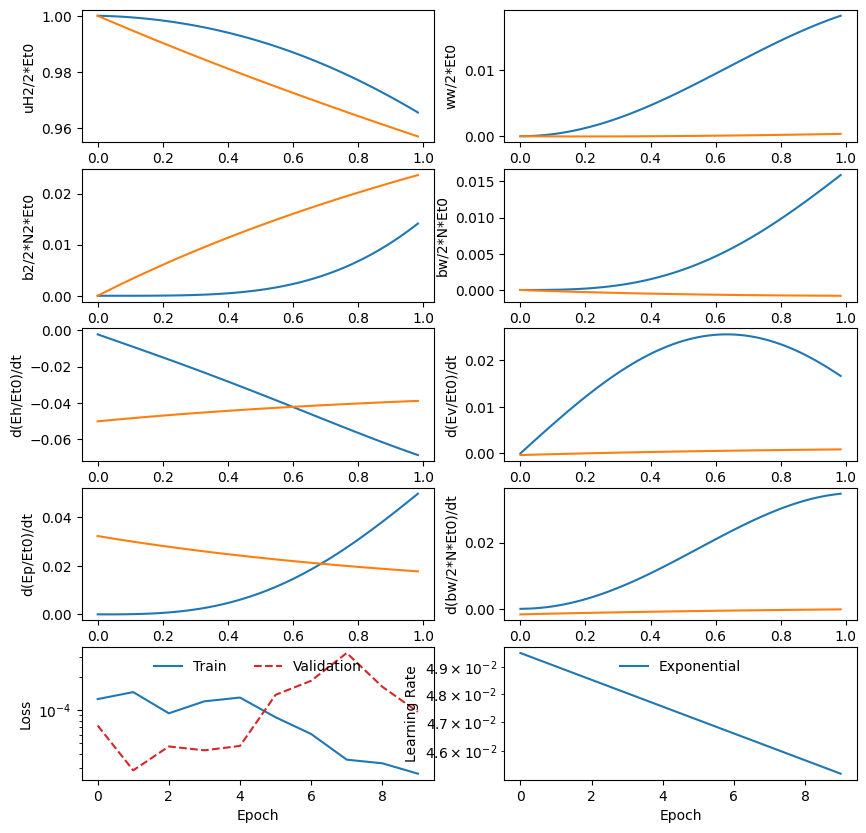

In [11]:
# device_name = torch.device('cuda')

# testing data for plotting
test_t = torch.from_numpy(train_time[0,:]).to(device_name, non_blocking=False)
test_y0 = train_IP_d[0,:].to(device_name, non_blocking=False)
# ODE solver solution for comparison
test_true_y = train_OP_d[0,:,:].to(device_name, non_blocking=False)
test_true_dy = torch.from_numpy(train_dydt[0,:,:]).to(device_name, non_blocking=False)

model2.to(device_name)
with torch.no_grad():
    _, pred_y, pred_dy = evaluate_NODE_model(model2, NODE_method2, NODE_rtol2, NODE_atol2, test_y0, test_t, test_true_y, loss_func2)
    args = test_t.cpu(), test_t.cpu(), test_true_y.cpu(), pred_y.cpu(), data_ip_varnames, test_true_dy.cpu(), pred_dy.cpu(), data_dy_varnames, \
            epoch_history2, train_loss_history2, val_loss_history2, lrate_history2
    plots.plot_train('RANS',args)
    plt.show()